In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)



Data Read and Pre-Processing

In [69]:
df = pd.read_csv('stock_data.csv')
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Nov 21, 2023",235.04,243.62,233.34,241.20,241.20,"122,288,000"
1,"Nov 20, 2023",234.04,237.10,231.02,235.60,235.60,"116,320,100"
2,"Nov 17, 2023",232.00,237.39,226.54,234.30,234.30,"142,532,800"
3,"Nov 16, 2023",239.49,240.88,230.96,233.59,233.59,"136,816,800"
4,"Nov 15, 2023",239.29,246.70,236.45,242.84,242.84,"150,354,000"


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1259 non-null   object 
 1   Open         1259 non-null   object 
 2   High         1257 non-null   float64
 3   Low          1257 non-null   float64
 4   Close*       1257 non-null   float64
 5   Adj Close**  1257 non-null   float64
 6   Volume       1257 non-null   object 
dtypes: float64(4), object(3)
memory usage: 69.0+ KB


In [71]:
print(df.isnull().sum())
df = df.dropna()

Date           0
Open           0
High           2
Low            2
Close*         2
Adj Close**    2
Volume         2
dtype: int64


In [72]:
df['Volume'] = df['Volume'].str.replace(',', '').astype(int)
df['Open'] = df['Open'].astype(float)
print(df.dtypes)

Date            object
Open           float64
High           float64
Low            float64
Close*         float64
Adj Close**    float64
Volume           int32
dtype: object


In [73]:
df['Date'] = pd.to_datetime(df['Date'])

In [74]:
df.describe()

,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1257,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,2021-05-24 18:31:13.031026176,166.453811,170.240827,162.362315,166.404057,166.404057,1.338908e+08
min,2018-11-23 00:00:00,12.070000,12.450000,11.800000,11.930000,11.930000,2.940180e+07
25%,2020-02-26 00:00:00,38.380000,39.630000,37.210000,38.150000,38.150000,7.969650e+07
50%,2021-05-25 00:00:00,194.420000,198.750000,189.920000,194.700000,194.700000,1.092510e+08
75%,2022-08-23 00:00:00,250.050000,254.980000,244.450000,250.970000,250.970000,1.586991e+08
max,2023-11-21 00:00:00,411.470000,414.500000,405.670000,409.970000,409.970000,9.140820e+08
std,NaN,109.868030,112.255981,107.173018,109.721794,109.721794,8.557588e+07


<Axes: >

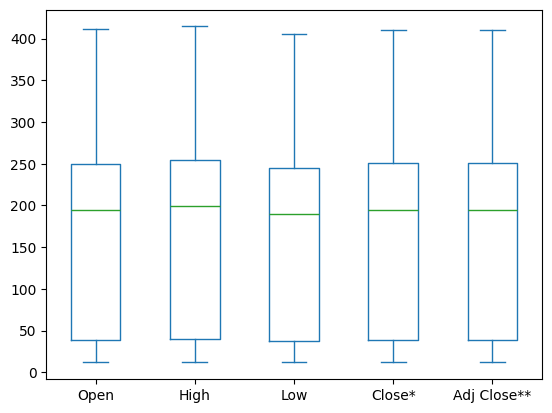

In [75]:
df[['Open','High','Low','Close*','Adj Close**']].plot(kind='box')

Feature Extraction

In [76]:
correlation_matrix = df[[ 'Date','Open','High','Low','Adj Close**','Volume']].corr().abs()

print(correlation_matrix)

upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)


                 Date      Open      High       Low  Adj Close**    Volume
Date         1.000000  0.761909  0.761837  0.762962     0.762276  0.249545
Open         0.761909  1.000000  0.999390  0.999146     0.998232  0.419147
High         0.761837  0.999390  1.000000  0.999170     0.999207  0.412249
Low          0.762962  0.999146  0.999170  1.000000     0.999292  0.425936
Adj Close**  0.762276  0.998232  0.999207  0.999292     1.000000  0.417634
Volume       0.249545  0.419147  0.412249  0.425936     0.417634  1.000000
['High', 'Low', 'Adj Close**']


In [77]:
#As Adj close has the maximum correlation with close so drop adj close
df = df.drop(['Adj Close**'], axis=1)

In [78]:
import statsmodels.api as sm

X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close*']

def backward_selection(X, y, significance_level=0.05):
    selected_features = X.columns.tolist()
    while len(selected_features) > 2:  # Keep 'High' and 'Low'
        X_with_intercept = sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_with_intercept).fit()
        max_p_value = model.pvalues[1:].max()  # Exclude the constant term
        if max_p_value > significance_level:
            excluded_feature = model.pvalues[1:].idxmax()
            selected_features.remove(excluded_feature)
        else:
            break
    return selected_features

selected_features_backward = backward_selection(X, y)
print(selected_features_backward)


['Open', 'High', 'Low']


In [79]:
#as backward selection shows volume is not much needed to predict closing so drop volume
df = df.drop(['Volume'], axis=1)

In [80]:
df

,Date,Open,High,Low,Close*
0,2023-11-21,235.04,243.62,233.34,241.20
1,2023-11-20,234.04,237.10,231.02,235.60
2,2023-11-17,232.00,237.39,226.54,234.30
3,2023-11-16,239.49,240.88,230.96,233.59
4,2023-11-15,239.29,246.70,236.45,242.84
...,...,...,...,...,...
1254,2018-11-29,23.13,23.17,22.64,22.74
1255,2018-11-28,23.07,23.22,22.81,23.19
1256,2018-11-27,22.67,23.13,22.37,22.93
1257,2018-11-26,21.67,23.08,21.67,23.07


In [81]:
layout = go.Layout(
    title = 'Stock Prices',
    xaxis=dict(
        title='Date',
        titlefont = dict(
            family = 'Courier New, monospace',
            size = 18,
            color = '#7f7f7f'
        )
    ),
    yaxis=dict(
        title = 'Price',
        titlefont= dict(
            family= 'Courier New, monospace',
            size = 18,
            color='#7f7f7f'
        )
    )
)
stock_data = [{'x':df['Date'], 'y':df['Close*']}]
plot = go.Figure(data=stock_data, layout=layout)

In [82]:
iplot(plot)

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [84]:
X = np.array(df.index).reshape(-1,1)
Y = df['Close*']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [85]:
scaler = StandardScaler().fit(x_train)

In [86]:
lm = LinearRegression()
lm.fit(x_train,y_train)

LinearRegression()

In [87]:
trace0 = go.Scatter(
    x= x_train.T[0],
    y=y_train,
    mode = 'markers',
    name = 'Actual'
)
trace1 = go.Scatter(
    x= x_train.T[0],
    y= lm.predict(x_train).T,
    mode = 'lines',
    name = 'Predicted'
)
stock_data = [trace0,trace1]
layout.xaxis.title.text = 'Day'
plot2 = go.Figure(data=stock_data,layout=layout)

In [88]:
iplot(plot2)

In [89]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Lists to store results
train_r2_scores = []
test_r2_scores = []
train_mse_scores = []
test_mse_scores = []

# Perform 3-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Standardize features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    lm.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = lm.predict(X_train_scaled)
    y_test_pred = lm.predict(X_test_scaled)

    # Evaluate the model
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mse(y_train, y_train_pred)
    test_mse = mse(y_test, y_test_pred)

    # Store results
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)

# Print average scores
print("Average Train R2 Score:", np.mean(train_r2_scores))
print("Average Test R2 Score:", np.mean(test_r2_scores))
print("Average Train MSE:", np.mean(train_mse_scores))
print("Average Test MSE:", np.mean(test_mse_scores))

Average Train R2 Score: 0.5813662444513749
Average Test R2 Score: 0.5807165029514805
Average Train MSE: 5034.066629665998
Average Test MSE: 5036.4247529120275


In [90]:
print(df)

           Date    Open    High     Low  Close*
0    2023-11-21  235.04  243.62  233.34  241.20
1    2023-11-20  234.04  237.10  231.02  235.60
2    2023-11-17  232.00  237.39  226.54  234.30
3    2023-11-16  239.49  240.88  230.96  233.59
4    2023-11-15  239.29  246.70  236.45  242.84
...         ...     ...     ...     ...     ...
1254 2018-11-29   23.13   23.17   22.64   22.74
1255 2018-11-28   23.07   23.22   22.81   23.19
1256 2018-11-27   22.67   23.13   22.37   22.93
1257 2018-11-26   21.67   23.08   21.67   23.07
1258 2018-11-23   22.29   22.50   21.70   21.72

[1257 rows x 5 columns]


Deep Learning 

In [91]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [92]:
df['Close*'] = pd.to_numeric(df['Close*'],errors='coerce')
df = df.dropna()
trainData = df.iloc[:,4:5]
trainData

,Close*
0,241.20
1,235.60
2,234.30
3,233.59
4,242.84
...,...
1254,22.74
1255,23.19
1256,22.93
1257,23.07


In [93]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)


In [94]:
x_train = []
y_train = []
for i in range(60,1257):
    x_train.append(trainData[i-60:i ,0])
    y_train.append(trainData[i,0])

x_train,y_train = np.array(x_train),np.array(y_train)

In [95]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1197, 60, 1)

In [96]:
model = Sequential()

model.add(LSTM(units = 100, return_sequences=True,input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [97]:
hist = model.fit(x_train,y_train,epochs=20,batch_size=32,verbose=2)

Epoch 1/20
38/38 - 20s - loss: 0.0296 - 20s/epoch - 513ms/step
Epoch 2/20
38/38 - 8s - loss: 0.0062 - 8s/epoch - 200ms/step
Epoch 3/20
38/38 - 7s - loss: 0.0050 - 7s/epoch - 193ms/step
Epoch 4/20
38/38 - 7s - loss: 0.0049 - 7s/epoch - 193ms/step
Epoch 5/20
38/38 - 7s - loss: 0.0049 - 7s/epoch - 185ms/step
Epoch 6/20
38/38 - 7s - loss: 0.0047 - 7s/epoch - 187ms/step
Epoch 7/20
38/38 - 7s - loss: 0.0039 - 7s/epoch - 181ms/step
Epoch 8/20
38/38 - 7s - loss: 0.0041 - 7s/epoch - 184ms/step
Epoch 9/20
38/38 - 7s - loss: 0.0045 - 7s/epoch - 188ms/step
Epoch 10/20
38/38 - 7s - loss: 0.0034 - 7s/epoch - 184ms/step
Epoch 11/20
38/38 - 7s - loss: 0.0034 - 7s/epoch - 187ms/step
Epoch 12/20
38/38 - 7s - loss: 0.0030 - 7s/epoch - 194ms/step
Epoch 13/20
38/38 - 7s - loss: 0.0027 - 7s/epoch - 195ms/step
Epoch 14/20
38/38 - 7s - loss: 0.0026 - 7s/epoch - 193ms/step
Epoch 15/20
38/38 - 7s - loss: 0.0030 - 7s/epoch - 189ms/step
Epoch 16/20
38/38 - 7s - loss: 0.0025 - 7s/epoch - 194ms/step
Epoch 17/20
38/

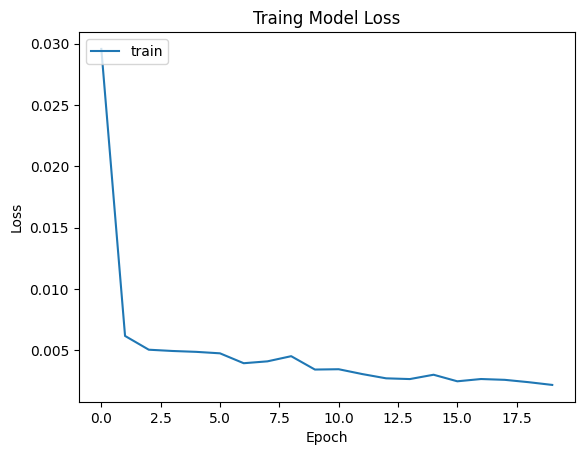

In [98]:
plt.plot(hist.history['loss'])
plt.title('Traing Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [99]:
testData = df.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values
inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
x_test = []
for i in range(60,len(testData)):
    x_test.append(inputClosing_scaled[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

C:\Users\DURRANI\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



(1197, 60, 1)

In [100]:
y_pred = model.predict(x_test)

38/38 [==============================] - 5s 61ms/step


In [101]:
predicted_price = sc.inverse_transform(y_pred)

In [102]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=1)

actual_trace = go.Scatter(x=df['Date'].iloc[60:], y=y_test.flatten(), mode='lines', name='Actual Stock Price', line=dict(color='red'))
fig.add_trace(actual_trace)

predicted_trace = go.Scatter(x=df['Date'].iloc[60:], y=predicted_price.flatten(), mode='lines', name='Predicted Stock Price', line=dict(color='green'))
fig.add_trace(predicted_trace)

fig.update_layout(
    title="Stock Price Prediction",
    xaxis=dict(title="Time"),
    yaxis=dict(title="Stock Price"),
    legend=dict(x=0, y=1, traceorder="normal", orientation="h"),
)

iplot(fig)
